<b> Function-level Vulnerability Prediction</b>

In [1]:
#!/usr/bin/env python
# coding: utf-8

# Import libraries
import seaborn as sn
import pandas as pd
import json, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from collections import defaultdict
import time
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW, Adam
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_

from transformers import set_seed
from transformers import AdamWeightDecay
from transformers import AutoTokenizer, RobertaTokenizer, AutoModelForSequenceClassification #, BertModel, BertTokenizer

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import logging


Basic Configuration of logging and seed

In [2]:
# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
# Define logger
logger = logging.getLogger(__name__)

# Specify a constant seeder for processes
seeders = [123456, 789012, 345678, 901234, 567890, 123, 456, 789, 135, 680]
seed = seeders[9]
logger.info(f"SEED: {seed}")
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

2025-02-27 16:25:14 - INFO - SEED: 680


Read data and model

In [3]:
# Read dataset
root_path = os.getcwd()
dataset = pd.read_csv(os.path.join(root_path, 'data', 'dataset.csv'))

In [4]:
# Model checkpoint and fine-tuning logic
FINE_TUNE = True  # Set this to False if you don't want to fine-tune the model and load from checkpoint

checkpoint_dir = './checkpoints'
save_path = os.path.join(checkpoint_dir, 'best_weights.pt')


In [5]:
# define functions
def save_checkpoint(filename, epoch, model, optimizer, scheduler, train_loss_per_epoch, val_loss_per_epoch, train_f1_per_epoch, val_f1_per_epoch):
    # If model is wrapped in DataParallel, save the underlying model's state_dict
    model_state_dict = model.module.state_dict() if torch.cuda.device_count() > 1 else model.state_dict()
    
    state = {
        'epoch': epoch,
        'model': model_state_dict,  # Use the correct state_dict
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_per_epoch': train_loss_per_epoch,
        'val_loss_per_epoch': val_loss_per_epoch,
        'train_f1_per_epoch': train_f1_per_epoch,
        'val_f1_per_epoch': val_f1_per_epoch
    }
    torch.save(state, filename)

def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    max_row = 0
    
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X['input_ids']):
        # Convert input_ids to a PyTorch tensor
        input_ids_tensor = torch.tensor(input_ids)
        # Calculate the length of the tokenized sequence for the current sample
        length = torch.sum(input_ids_tensor != tokenizer.pad_token_id).item()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    logger.info(f"Max length of tokenized data: {max_length}")
    logger.info(f"Row with max length:: {max_row}")
    
    return max_length


Get tokenizer

In [6]:
# Pre-trained tokenizer
model_variation = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#bert-base-uncased #bert-base # roberta-base # distilbert-base-uncased #distilbert-base # microsoft/codebert-base-mlm
# 'albert-base-v2'

# tokenizer = RobertaTokenizer(vocab_file="../../tokenizer_training/cpp_tokenizer/cpp_tokenizer-vocab.json",
#                              merges_file="../../tokenizer_training/cpp_tokenizer/cpp_tokenizer-merges.txt")


/home/iliaskaloup/anaconda3/envs/torchenv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Split data sets and explore data

In [7]:
# View the largest projects

logger.info(f"List of projects in BigVul: {dataset['project'].unique()}")
logger.info(f"Number of different projects in BigVul: {len(dataset['project'].unique())}")

project_counts = dataset['project'].value_counts().nlargest(10)
logger.info(f"Top-10 largest projects in BigVul and their size: {project_counts}")

# Choose the selected project to include in the test set.
# default = "all"
selected_project = "all" # all # Chrome # linux # Android # qemu # php # ImageMagick # savannah # FFmpeg # ghostscript # openssl


2025-02-27 16:25:53 - INFO - List of projects in BigVul: ['openssl' 'linux' 'Chrome' 'poppler' 'libpcap' 'gpac' 'libarchive'
 'suricata' 'libexpat' 'mbedtls' 'unixODBC' 'libreport' 'keepalived'
 'Android' 'radare2' 'savannah' 'lynx-snapshots' 'libming' 'php' 'qemu'
 'tor' 'uncurl' 'ghostscript' 'ImageMagick' 'memcached' 'samba' 'miniupnp'
 'FreeRDP' 'OpenSC' 'wireshark' 'ImageMagick6' 'FFmpeg' 'minisphere'
 'jasper' 'OpenJK' 'Onigmo' 'imageworsener' 'gst-plugins-ugly'
 'php-radius' 'polarssl' 'libssh' 'spice' 'libgd' 'mruby' 'neomutt' 'dbus'
 'ovs' 'libimobiledevice' 'gnupg' 'oniguruma' 'mod_auth_openidc'
 'nautilus' 'ppp' 'tcpdump' 'wolfssl' 'raptor' 'VeraCrypt' 'udisks' 'exim'
 'kde' 'harfbuzz' 'curl' 'redis' 'h2o' 'lxc' 'libtiff' 'wayland'
 'htcondor' 'mindrot' 'irssi' 'abrt' 'php-src' 'ntp' 'rdesktop' 'uzbl'
 'mujs' 'profanity' 'file' 'jansson' 'cyrus-imapd' 'Espruino' 'postgres'
 'heimdal' 'w3m' 'u-boot' 'netfilter' 'zstd' 'gstreamer' 'axtls-8266'
 'launchpad' 'leptonica' 'postgre

In [8]:
# data split
val_ratio = 0.1
num_of_ratio = int(val_ratio * len(dataset))
data = dataset.iloc[0:-num_of_ratio, :]
test_data = dataset.iloc[-num_of_ratio:, :]
train_data = data.iloc[0:-num_of_ratio, :]
val_data = data.iloc[-num_of_ratio:, :]

# if selected_project=="all" continue with the whole test_set, else, if one specific project is selected keep only its samples
if selected_project != "all":
    test_data = test_data[test_data['project'] == selected_project]

# Shuffle dataset

train_data = train_data.sample(frac=1, random_state=seed).reset_index(drop=True)
logger.info(f"Train data head: {train_data.head()}")
logger.info(f"Length of training data: {len(train_data)}")


#train_data = train_data[train_data["project"] != "Chrome"]
#logger.info(f"Length of training data without Chromium: {len(train_data)}")


train_data = train_data[["processed_func", "target", "flaw_line", "flaw_line_index"]]
train_data.head()


# Explore data

train_data = train_data.dropna(subset=["processed_func"])


word_counts = train_data["processed_func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
logger.info(f"Maximum number of words: {max_length}")


vc = train_data["target"].value_counts()

logger.info(f"Value counts of training data: {vc}")

logger.info(f"Percentages of classes: {(vc[1] / vc[0])*100, '%'}")

n_categories = len(vc)
logger.info(f"Number of categories: {n_categories}")

train_data = pd.DataFrame(({'Text': train_data['processed_func'], 'Labels': train_data['target'], 'Lines':train_data['flaw_line'], 'Line_Index':train_data['flaw_line_index']}))
#train_data = train_data[0:100]
train_data.head()


#val_data = val_data[val_data["project"] != "Chrome"]

val_data = pd.DataFrame(({'Text': val_data['processed_func'], 'Labels': val_data['target'], 'Lines':val_data['flaw_line'], 'Line_Index':val_data['flaw_line_index']}))
val_data.head()


#test_data = test_data[test_data["project"] != "Chrome"]

test_data = pd.DataFrame(({'Text': test_data['processed_func'], 'Labels': test_data['target'], 'Lines':test_data['flaw_line'], 'Line_Index':test_data['flaw_line_index']}))

logger.info(f"Train data length: {len(train_data)}")
logger.info(f"Validation data length: {len(val_data)}")
logger.info(f"Test data length: {len(test_data)}")

2025-02-27 16:25:53 - INFO - Train data head:     index Access Gained Attack Origin Authentication Required Availability  \
0   48018           NaN         Local            Not required      Partial   
1  177287           NaN        Remote            Not required     Complete   
2  174089           NaN        Remote            Not required          NaN   
3   31021           NaN         Local            Not required          NaN   
4  120877           NaN        Remote            Not required          NaN   

          CVE ID                                       CVE Page   CWE ID  \
0  CVE-2016-9588  https://www.cvedetails.com/cve/CVE-2016-9588/  CWE-388   
1  CVE-2016-2476  https://www.cvedetails.com/cve/CVE-2016-2476/  CWE-119   
2  CVE-2016-2460  https://www.cvedetails.com/cve/CVE-2016-2460/  CWE-200   
3  CVE-2013-2635  https://www.cvedetails.com/cve/CVE-2013-2635/  CWE-399   
4  CVE-2013-2879  https://www.cvedetails.com/cve/CVE-2013-2879/  CWE-200   

  Complexity Confidentiality

Pre-processing

In [9]:
# Pre-processing step: Under-sampling

sampling = False
if n_categories == 2 and sampling == True:
    # Apply under-sampling with the specified strategy
    class_counts = pd.Series(train_data["Labels"]).value_counts()
    print("Class distribution ", class_counts)

    majority_class = class_counts.idxmax()
    print("Majority class ", majority_class)

    minority_class = class_counts.idxmin()
    print("Minority class ", minority_class)

    target_count = 4 * class_counts[class_counts.idxmin()] # int(class_counts[class_counts.idxmax()] / 2) # 2 * class_counts[class_counts.idxmin()] # class_counts[class_counts.idxmin()] # int(class_counts.iloc[0] / 2)
    print("Targeted number of majority class", target_count)

    # under
    sampling_strategy = {majority_class: target_count}
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)

    x_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_data["Text"]).reshape(-1, 1), train_data["Labels"])
    print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())


    # Shuffle the resampled data while preserving the correspondence between features and labels
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

    # rename
    X_train = x_train_resampled
    Y_train = y_train_resampled

    X_train = pd.Series(X_train.reshape(-1))

else:
    X_train = train_data["Text"]
    Y_train = train_data["Labels"]


Get model and apply tokenizer

In [10]:
# Pre-trained model

model = AutoModelForSequenceClassification.from_pretrained(model_variation, num_labels=n_categories)
# Resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)


# # Compute maximum length

# X = tokenizer(
#         text=X_train.tolist(),
#         add_special_tokens=True,
#         max_length=512,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         return_token_type_ids=False,
#         return_attention_mask=True,
#         verbose=True
#     )

# max_len = getMaxLen(X)
max_len = 512

# Tokenization

X_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)


X_val = tokenizer(
    text=val_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)


X_test = tokenizer(
    text=test_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model preparation

In [11]:
# Hyper-parameters

n_epochs = 10
lr = 2e-5 #5e-05
batch_size = 8 #16
patience = 5

optimizer = AdamW(model.parameters(),
                  lr = lr, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

In [12]:
# Build Model

Y_train = torch.LongTensor(Y_train.tolist())
Y_val = torch.LongTensor(val_data["Labels"].tolist())
Y_test = torch.LongTensor(test_data["Labels"].tolist())
Y_train.size(), Y_val.size(), Y_test.size()


train_dataset = TensorDataset(X_train["input_ids"], X_train["attention_mask"], Y_train)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(X_val["input_ids"], X_val["attention_mask"], Y_val)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(X_test["input_ids"], X_test["attention_mask"], Y_test)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)


max_steps = len(train_dataloader)*n_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
            num_warmup_steps=max_steps // 5,
            num_training_steps=max_steps)

loss_fun = nn.CrossEntropyLoss()

# total_steps = len(train_dataloader) * n_epochs

# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, # Default value in run_glue.py
#                                             num_training_steps = total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Device {device}")

print(model.to(device))
print("No. of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))


2025-02-27 16:26:27 - INFO - Device cuda


DataParallel(
  (module): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): 

In [13]:
# # we do not retrain our pre-trained BERT and train only the last linear dense layer
# for param in model.roberta.parameters():
#     param.requires_grad = False

Training loop - Fine-tuning

In [14]:
if not FINE_TUNE and os.path.exists(save_path):
    pass
else:
    logger.info(f"Fine-tuning model: {model_variation}")
    # Train model
    
    # Initialize values for implementing Callbacks
    ## Early Stopping
    best_val_f1 = -1
    best_epoch = -1
    no_improvement_counter = 0
    ## Save best - optimal checkpointing
    #checkpoint_dir = './checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    #save_path = os.path.join(checkpoint_dir, 'best_weights.pt')
    
    print("Training...")
    milli_sec1 = int(round(time.time() * 1000))

    logger.info("Starting training...")
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    train_f1_per_epoch = []
    val_f1_per_epoch = []
    
    for epoch_num in range(n_epochs):
        logger.info(f'Epoch: {epoch_num + 1}')
    
        #Training
        model.train()
        train_loss = 0
        total_preds = []
        total_labels = []
        for step_num, batch_data in enumerate(tqdm(train_dataloader, desc='Training')):
    
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
    
            # clear previously calculated gradients
            model.zero_grad() # optimizer.zero_grad()
    
            # get model predictions for the current batch
            output = model(input_ids = input_ids, attention_mask=att_mask) # , labels=labels
    
            # compute the loss between actual and predicted values
            loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]
            # add on to the total loss
            train_loss += loss.item()
    
            # backward pass to calculate the gradients
            loss.backward()
    
            # clip the gradients to 1.0. It helps in preventing the exploding gradient problem
            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
    
            # update parameters
            optimizer.step()
            scheduler.step()
    
            # Print training loss after each batch
            #print("Epoch {}/{} - Batch {}/{} - Training Loss: {:.4f}".format(epoch_num+1, n_epochs, step_num+1, len(train_dataloader), loss.item()))
    
            # model predictions are stored on GPU. So, push it to CPU
            preds = np.argmax(output.logits.cpu().detach().numpy(),axis=-1)
            # append the model predictions
            total_preds+=list(preds)
            total_labels+=labels.cpu().numpy().tolist()
    
        train_loss_per_epoch.append(train_loss / len(train_dataloader))
        train_accuracy=accuracy_score(total_labels, total_preds)
        if n_categories > 2:
            train_precision=precision_score(total_labels, total_preds, average='macro')
            train_recall=recall_score(total_labels, total_preds, average='macro')
            train_f1=f1_score(total_labels, total_preds, average='macro')
        else:
            train_precision=precision_score(total_labels, total_preds)
            train_recall=recall_score(total_labels, total_preds)
            train_f1=f1_score(total_labels, total_preds)
            train_roc_auc=roc_auc_score(total_labels, total_preds)
        train_f2 = (5*train_precision*train_recall) / (4*train_precision+train_recall)
    
        #Validation
        model.eval()
        valid_loss = 0
        valid_pred = []
        actual_labels = []
        with torch.no_grad():
            for step_num_e, batch_data in enumerate(tqdm(val_dataloader, desc='Validation')):
                input_ids, att_mask, labels = [data.to(device) for data in batch_data]
    
                output = model(input_ids = input_ids, attention_mask=att_mask) # , labels=labels
    
                preds = np.argmax(output.logits.cpu().detach().numpy(), axis=-1)
                valid_pred+=list(preds)
                actual_labels+=labels.cpu().numpy().tolist()
    
                loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]
                valid_loss += loss.item()
    
        val_loss_per_epoch.append(valid_loss / len(val_dataloader))
        val_accuracy=accuracy_score(actual_labels, valid_pred)
        if n_categories > 2:
            val_precision=precision_score(actual_labels, valid_pred, average='macro')
            val_recall=recall_score(actual_labels, valid_pred, average='macro')
            val_f1=f1_score(actual_labels, valid_pred, average='macro')
        else:
            val_precision=precision_score(actual_labels, valid_pred)
            val_recall=recall_score(actual_labels, valid_pred)
            val_f1=f1_score(actual_labels, valid_pred)
            val_roc_auc=roc_auc_score(actual_labels, valid_pred)
        val_f2 = (5*val_precision*val_recall) / (4*val_precision+val_recall)
    
        #print("Epoch {}/{} - Train Loss: {:.4f} - Valid Loss: {:.4f}".format(epoch_num+1, n_epochs, train_loss_per_epoch[-1], val_loss_per_epoch[-1]))
        #print("Epoch {}/{} - Train F1: {:.4f} - Valid F1: {:.4f}".format(epoch_num+1, n_epochs, train_f1, val_f1))
        logger.info(f"Epoch {epoch_num + 1}/{n_epochs} - Train Loss: {train_loss_per_epoch[-1]:.4f} - Valid Loss: {val_loss_per_epoch[-1]:.4f}")
        logger.info(f"Epoch {epoch_num + 1}/{n_epochs} - Train F1: {train_f1:.4f} - Valid F1: {val_f1:.4f}")

    
        train_f1_per_epoch.append(train_f1)
        val_f1_per_epoch.append(val_f1)
    
        total_epochs = epoch_num + 1
        # Implement Callbacks: Early Stopping and save best
        # Check if the validation F1 score has improved
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch_num + 1
            no_improvement_counter = 0 # Reset the counter
    
            # Save the best model checkpoint
            save_checkpoint(save_path, epoch_num+1, model, optimizer.state_dict(), scheduler.state_dict(), train_loss_per_epoch, val_loss_per_epoch, train_f1_per_epoch, val_f1_per_epoch)
            logger.info(f"Model saved at epoch {epoch_num + 1}")
        else:
            no_improvement_counter += 1
    
            if no_improvement_counter >= patience:
                # print("No improvement for", patience, "consecutive epochs.")
                # print("Early stopping after epoch No.", total_epochs)
                # print("Best model after epoch No", best_epoch)
                # print("Best achieved val_f1 = ", best_val_f1)
                logger.info(f"Early stopping after epoch {total_epochs}. Best epoch: {best_epoch} with best F1 score: {best_val_f1:.4f}")
                break

    milli_sec2 = int(round(time.time() * 1000))
    print("Training is completed after", milli_sec2-milli_sec1)

    epochs = range(1, total_epochs + 1)
    fig, ax = plt.subplots()
    ax.plot(epochs, train_loss_per_epoch, label ='training loss')
    ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
    ax.set_title('Training and Validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    #plt.show()
    plt.savefig('losses.png')
    plt.close()
    
    
    epochs = range(1, total_epochs + 1)
    fig, ax = plt.subplots()
    ax.plot(epochs, train_f1_per_epoch, label = 'training F1-score')
    ax.plot(epochs, val_f1_per_epoch, label = 'validation F1-score')
    ax.set_title('Training and Validation F1-scores')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1-score')
    ax.legend()
    #plt.show()
    plt.savefig('f-scores.png')
    plt.close()

2025-02-27 16:26:27 - INFO - Fine-tuning model: microsoft/codebert-base
2025-02-27 16:26:27 - INFO - Starting training...
2025-02-27 16:26:27 - INFO - Epoch: 1


Training...


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2358/2358 [01:47<00:00, 21.85it/s]
2025-02-27 17:09:46 - INFO - Epoch 1/10 - Train Loss: 0.1140 - Valid Loss: 0.0765
2025-02-27 17:09:46 - INFO - Epoch 1/10 - Train F1: 0.7500 - Valid F1: 0.8647
2025-02-27 17:09:48 - INFO - Model saved at epoch 1
2025-02-27 17:09:48 - INFO - Epoch: 2
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2358/2358 [01:47<00:00, 21.86it/s]
2025-02-27 17:53:05 - INFO - Epoch 2/10 - Train Loss: 0.0723 - Valid Loss: 0.0715
2025-02-27 17:53:05 - INFO - Epoch 2/10 - Train F1: 0.8691 - Valid F1: 0.8774
2025-02-27 17:53:06 - INFO - Model saved at epoch 2
2025-02-27 17:53:06 - INFO - Epoch: 3
Validation: 100%|███████

Training is completed after 25986401


Execution loop

In [15]:
# Load best model from checkpoint during training with early stopping

checkpoint = torch.load(save_path, map_location=device)
# If model is wrapped in DataParallel, load state_dict directly into the underlying model
if torch.cuda.device_count() > 1:
    model.module.load_state_dict(checkpoint['model'])
else:
    model.load_state_dict(checkpoint['model'])
model.to(device)

# Make predictions on the testing set
logger.info("Starting testing...")
test_start_time = time.time()
model.eval()
test_pred = []
test_probas_pred = []
actual_labels = []
test_loss = 0
with torch.no_grad():
    for step_num, batch_data in enumerate(tqdm(test_dataloader, desc='Testing')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]

        output = model(input_ids = input_ids, attention_mask=att_mask) #, labels= labels

        loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]
        test_loss += loss.item()

        logits_array = output.logits.cpu().detach().numpy()
        #probs_array = softmax(logits_array, axis=1)
        probs_array = torch.softmax(torch.tensor(logits_array), dim=-1).numpy()
        
        preds = np.argmax(probs_array , axis=-1)
        test_pred+=list(preds)
        actual_labels+=labels.cpu().numpy().tolist()

        probas = np.max(probs_array , axis=1)
        test_probas_pred+=list(probas)

/tmp/ipykernel_1021129/1291369573.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)
2025-02-27 23:39:34 - INFO - St

Evaluation process

2025-02-27 23:41:23 - INFO - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17808
           1       0.96      0.87      0.91      1055

    accuracy                           0.99     18863
   macro avg       0.97      0.93      0.95     18863
weighted avg       0.99      0.99      0.99     18863



Testing is completed after 108.55353713035583
Perception time is 0
Accuracy:99.03%
Precision:95.61%
Recall:86.64%
F1 score:90.90%
F2 score:88.29%
Roc_Auc score:93.20%
TP= 914
TN= 17766
FP= 42
FN= 141


<Axes: >

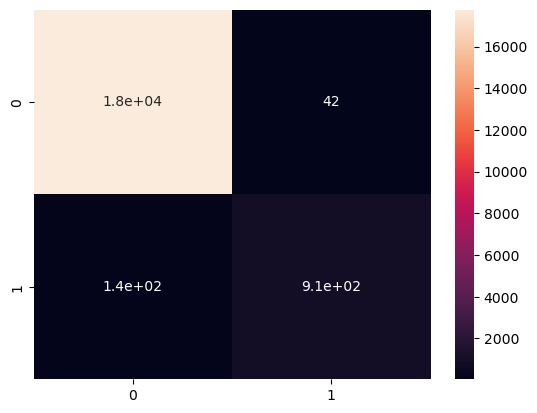

In [16]:
# compute evaluation metrics
class_report = classification_report(actual_labels, test_pred)
logger.info(f"Classification Report:\n{class_report}")
test_end_time = time.time()
testing_time = test_end_time - test_start_time
print("Testing is completed after", testing_time)
print("Perception time is", int(testing_time/len(test_pred)))

total_test_loss = test_loss/len(test_dataloader)
accuracy=accuracy_score(actual_labels, test_pred)
if n_categories > 2:
    precision=precision_score(actual_labels, test_pred, average='macro')
    recall=recall_score(actual_labels, test_pred, average='macro')
    f1=f1_score(actual_labels, test_pred, average='macro')
else:
    precision=precision_score(actual_labels, test_pred)
    recall=recall_score(actual_labels, test_pred)
    f1=f1_score(actual_labels, test_pred)
    roc_auc=roc_auc_score(actual_labels, test_pred)
f2 = (5*precision*recall) / (4*precision+recall)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))
if roc_auc:
    print("Roc_Auc score:%.2f%%"%(roc_auc*100))

conf_matrix = confusion_matrix(actual_labels, test_pred)
tn, fp, fn, tp = conf_matrix.ravel()
#acc = ((tp+tn)/(tp+tn+fp+fn))

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)
#print(conf_matrix)
sn.heatmap(conf_matrix, annot=True)


In [17]:
# Export classification report

method = "forSequence"


# Create the path
path = os.path.join(root_path, 'results', model_variation.split("/")[-1], method, str(seed))

# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(path, f"{seed}.csv")

# Write data to CSV
data = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "f2": f2,
    "roc_auc": roc_auc
}

# Write to CSV
with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data.keys())
    writer.writeheader()
    writer.writerow(data)


# Compute the average values of the classication metrics considering the results for all different seeders

# Define a dictionary to store cumulative sum of metrics
cumulative_metrics = defaultdict(float)
count = 0  # Counter to keep track of number of CSV files

# Iterate over all CSV files in the results folder
results_folder = os.path.join(root_path, "results", model_variation.split("/")[-1], method)

for root, dirs, files in os.walk(results_folder):
    for filename in files:
        if filename.endswith(".csv") and filename != "avg.csv":
            csv_file_path = os.path.join(root, filename)

            with open(csv_file_path, "r", newline="") as csvfile:
                reader = csv.DictReader(csvfile)

                for row in reader:
                    for metric, value in row.items():
                        cumulative_metrics[metric] += float(value)
            count += 1

# Compute average values
average_metrics = {metric: total / count for metric, total in cumulative_metrics.items()}

# Print average values
print(average_metrics)

# Define the path for the average CSV file
avg_csv_file_path = os.path.join(root_path, "results", model_variation.split("/")[-1], method, "avg.csv")

# Write average metrics to CSV
with open(avg_csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=average_metrics.keys())
    writer.writeheader()
    writer.writerow(average_metrics)

# # Clean up
# del model
# torch.cuda.empty_cache()

{'accuracy': 0.9904310024916503, 'precision': 0.9561878360411281, 'recall': 0.8688151658767772, 'f1': 0.9103592081346781, 'f2': 0.8849587891258468, 'roc_auc': 0.9332255299285054}


<b> Line-level Vulnerability Detection</b>

In [18]:
import lime
import shap
from lime.lime_text import LimeTextExplainer
from transformers import pipeline
from captum.attr import DeepLiftShap

In [19]:
# Eliminate Test samples that are vulnerable (target=1) but they have missing line-level labels (flaw lines is nan)
REMOVE_MISSING_LINE_LABELS = True # True # False

if REMOVE_MISSING_LINE_LABELS:

    test_data = test_data.reset_index(drop=True)
    test_data = test_data[~((test_data['Labels'] == 1) & (test_data['Line_Index'].isna()))]
    test_data = test_data.reset_index(drop=True)
    Y_test = torch.LongTensor(test_data["Labels"].tolist())
    
    
    X_test = tokenizer(
        text=test_data['Text'].tolist(),
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='pt',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    
    test_dataset = TensorDataset(X_test["input_ids"], X_test["attention_mask"], Y_test)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)
    
    # Make new predictions
    logger.info("Starting testing...")
    test_start_time = time.time()
    model.eval()
    test_pred = []
    test_probas_pred = []
    actual_labels = []
    test_loss = 0
    with torch.no_grad():
        for step_num, batch_data in enumerate(tqdm(test_dataloader, desc='Testing')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
    
            output = model(input_ids = input_ids, attention_mask=att_mask) #, labels= labels
    
            loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]
            test_loss += loss.item()
    
            logits_array = output.logits.cpu().detach().numpy()
            #probs_array = softmax(logits_array, axis=1)
            probs_array = torch.softmax(torch.tensor(logits_array), dim=-1).numpy()
            
            preds = np.argmax(probs_array , axis=-1)
            test_pred+=list(preds)
            actual_labels+=labels.cpu().numpy().tolist()
    
            probas = np.max(probs_array , axis=1)
            test_probas_pred+=list(probas)
    
    # compute evaluation metrics
    new_class_report = classification_report(actual_labels, test_pred)
    logger.info(f"Classification Report:\n{new_class_report}")


2025-02-27 23:41:27 - INFO - Starting testing...
Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2325/2325 [01:46<00:00, 21.73it/s]
2025-02-27 23:43:14 - INFO - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17808
           1       0.95      0.93      0.94       788

    accuracy                           0.99     18596
   macro avg       0.97      0.97      0.97     18596
weighted avg       0.99      0.99      0.99     18596



In [20]:
# Function to tokenize the function into lines and tokens
def tokenize_function_to_lines_and_tokens(function_code, split_char):
    # Split function into lines based on newline characters
    lines = function_code.split(split_char)
    
    # Tokenize each line
    tokenized_lines = []
    for line in lines:
        tokens = tokenizer.tokenize(line)
        tokenized_lines.append(tokens)
    
    return lines, tokenized_lines

In [21]:
# Identify negative predictions ie TN and FN
negative_indices = [i for i, pred in enumerate(test_pred) if pred == 0]  # Indices of Negative predictions (TNs + FNs)

# Collect lines of negative predictions
negative_samples = [test_data['Text'].tolist()[i] for i in negative_indices]  # Extract Negative samples from test data

# Flatten
all_neg_lines = []
for neg_func in negative_samples:
    neg_lines, _ = tokenize_function_to_lines_and_tokens(neg_func, '\n')
    for neg_line in neg_lines:
        all_neg_lines.append(neg_line)

In [22]:
EXPLAINER = "ATTENTION"  # or "LIME" or "DEEPLIFTSHAP" or "ATTENTION" based on user choice
logger.info(f"Initializing {EXPLAINER} explainer for Positive predictions...")

EXPLAIN_ONLY_TP_Accuracy = True
EXPLAIN_ONLY_TP_CostEffect = False

EXPLAIN_ONLY_TP = EXPLAIN_ONLY_TP_CostEffect

2025-02-27 23:43:29 - INFO - Initializing ATTENTION explainer for Positive predictions...


In [23]:
# Identify True Positives (where the predicted label and actual label are both 1)
true_positive_indices = [i for i, (pred, label) in enumerate(zip(test_pred, Y_test.tolist())) if pred == 1 and label == 1]
if EXPLAIN_ONLY_TP:
    positive_indices = true_positive_indices
    logger.info(f"Selected {len(true_positive_indices)} True Positives for explanations.")
else:
    # Identify True Positives and False Positives
    trueNfalse_positive_indices = [i for i, pred in enumerate(test_pred) if pred == 1]  # Indices of Positive predictions (TPs + FPs)
    logger.info(f"Generating explanations for {len(trueNfalse_positive_indices)} Positive predictions (TPs and FPs)...")
    positive_indices = trueNfalse_positive_indices

actual_positive_indices = [i for i, label in enumerate(Y_test.tolist()) if label == 1]  # Indices of Actual Positive predictions (TPs + FNs)


2025-02-27 23:43:29 - INFO - Generating explanations for 778 Positive predictions (TPs and FPs)...


In [24]:
positive_samples = [test_data['Text'].tolist()[i] for i in positive_indices]  # Extract Positive samples from test data

positive_probas = [test_probas_pred[i] for i in positive_indices]

In [25]:
# Function to predict probabilities for LIME
def predict_proba_func_lime(texts):
    model.eval()
    encodings = tokenizer(
        texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=max_len
    ).to(device)

    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits.cpu().numpy()
        
    probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    
    return probabilities

In [26]:
# Function to initialize the explainer (LIME or SHAP)
def initialize_explainer():
    if EXPLAINER == "LIME":
        model.to(device)
        return LimeTextExplainer(class_names=['Non-Vulnerable', 'Vulnerable'], random_state=seed)
    elif EXPLAINER == "DEEPLIFTSHAP":
        model.to(device)
        return DeepLiftShap(model)  # Initialize DeepLiftShap with the model
    else:
        raise ValueError(f"Unknown explainer: {EXPLAINER}")

# Initialize the explainer
if EXPLAINER == "LIME" or EXPLAINER == "DEEPLIFTSHAP":
    explainer = initialize_explainer()

In [27]:
# Function to compute LIME values for each line by summing the token-level values
def compute_lime_values_per_line(tokenized_lines, token_scores_dict):
    line_lime_scores = []

    # Iterate over tokenized lines
    for tokens in tokenized_lines:
        line_score = 0  # Initialize line score
        for token in tokens:
            # Retrieve the LIME score for the token if it exists
            if token in token_scores_dict:
                line_score += token_scores_dict[token]
        
        # Store the summed LIME score for the line
        line_lime_scores.append(line_score)
    
    return line_lime_scores

# Function to compute DeepLiftSHAP values for each line by summing the token-level values
def compute_deepliftshap_values_per_line(tokenized_lines, token_attributions):
    line_deepliftshap_scores = []

    token_idx = 0
    for tokens in tokenized_lines:
        line_score = sum(token_attributions[token_idx:token_idx+len(tokens)])
        line_deepliftshap_scores.append(line_score)
        token_idx += len(tokens)
    
    return line_deepliftshap_scores

# Function to compute attention values for each line
def compute_attention_values_per_line(tokenized_lines, attention_scores):
    line_scores = []
    token_idx = 0  # Keeps track of the token index
    
    for tokens in tokenized_lines:
        line_score = sum(attention_scores[token_idx:token_idx+len(tokens)])
        line_scores.append(line_score)
        token_idx += len(tokens)
    
    return line_scores

# Function to clean special token values (<s>, </s>, padding)
def clean_special_token_values(all_values, padding=True):
    # Special token in the beginning of the sequence
    all_values[0] = 0
    if padding:
        # Set the last non-zero value (representing the </s> token) to zero
        idx = [index for index, item in enumerate(all_values) if item != 0][-1]
        all_values[idx] = 0
    else:
        # Special token at the end of the sequence
        all_values[-1] = 0
    return all_values

XAI-based localization

In [28]:
# Initialize a list to store the LIME explanations
explanation_results = []
# Loop through all positive samples (True Positives and False Positives)
for i, sample in enumerate(positive_samples):

    if EXPLAINER == "LIME":
        # Print logs every 10 samples
        if (i + 1) % 10 == 0:
            logger.info(f"Generating LIME explanation for sample {i + 1}/{len(positive_samples)}")
        
        # Generate explanation using the LIME explainer
        explanation = explainer.explain_instance(
            sample,  # The text/code snippet to explain
            predict_proba_func_lime,  # The function to predict probabilities
            num_features=20,  # Number of features to include in the explanation
            num_samples = 50,
            labels=[1]  # Target class (Vulnerable)
        )

    elif EXPLAINER == "DEEPLIFTSHAP":
        # Print logs every 10 samples
        if (i + 1) % 10 == 0:
            logger.info(f"Generating DEEPLIFTSHAP explanation for sample {i + 1}/{len(positive_samples)}")
        
        # Generate explanation using the SHAP explainer
        # Tokenize the function into lines and tokens
        lines, tokenized_lines = tokenize_function_to_lines_and_tokens(sample, '\n')

        # Encode the sample (input) and get embeddings
        encodings = tokenizer(sample, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)

        # Get the embeddings for input ids using the model's embedding layer
        input_embeddings = model.get_input_embeddings()(encodings['input_ids'])

        # Compute DeepLiftSHAP values per token
        num_baselines = 16
        baseline_inputs = torch.zeros_like(input_embeddings).repeat((num_baselines, 1, 1)).to(device)

        attributions = explainer.attribute(inputs=input_embeddings, baselines=baseline_inputs)

        # Convert attributions to a list of token-level attributions
        token_attributions = attributions.squeeze().tolist()

        # Clean attributions for special tokens (e.g., <s>, </s>, padding)
        token_attributions = clean_special_token_values(token_attributions, padding=True)

        # Compute DeepLiftSHAP values per line
        line_deepliftshap_scores = compute_deepliftshap_values_per_line(tokenized_lines, token_attributions)

        # Create a list of tuples containing (line_index, line_text, deepliftshap_score)
        explanation = [(line_idx, line, line_deepliftshap_scores[line_idx]) for line_idx, line in enumerate(lines)]

    
    elif EXPLAINER == "ATTENTION":
        # Print logs every 10 samples
        if (i + 1) % 10 == 0:
            logger.info(f"Generating ATTENTION-based explanation for sample {i + 1}/{len(positive_samples)}")
        
        # Tokenize the function into lines and tokens
        lines, tokenized_lines = tokenize_function_to_lines_and_tokens(sample, '\n')
        
        # Get model predictions along with attention weights
        with torch.no_grad():
            encodings = tokenizer(sample, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)
            outputs = model(**encodings, output_attentions=True)
            logits = outputs.logits.cpu().detach().numpy()
            attentions = outputs.attentions  # Attention weights from each layer 

        batch_attention = attentions[0][0]

        # Summarize across heads by averaging the attention scores
        attention_summary = torch.mean(batch_attention, dim=0).cpu().numpy()  # Average across heads

        # Sum the attention each token receives from others (this gives a score for each token)
        token_attention_scores = np.sum(attention_summary, axis=0)  # Shape: (sequence_length,)

         # Clean attention scores for special tokens (e.g., <s>, </s>, padding)
        token_attention_scores = clean_special_token_values(token_attention_scores, padding=True)

        # Compute attention values per line
        line_attention_scores = compute_attention_values_per_line(tokenized_lines, token_attention_scores)

        # Create a list of tuples containing (line_index, line_text, attention_score)
        explanation = [(line_idx, line, line_attention_scores[line_idx]) for line_idx, line in enumerate(lines)]
    
    explanation_results.append(explanation)

2025-02-27 23:43:30 - INFO - Generating ATTENTION-based explanation for sample 10/778
2025-02-27 23:43:30 - INFO - Generating ATTENTION-based explanation for sample 20/778
2025-02-27 23:43:30 - INFO - Generating ATTENTION-based explanation for sample 30/778
2025-02-27 23:43:30 - INFO - Generating ATTENTION-based explanation for sample 40/778
2025-02-27 23:43:30 - INFO - Generating ATTENTION-based explanation for sample 50/778
2025-02-27 23:43:30 - INFO - Generating ATTENTION-based explanation for sample 60/778
2025-02-27 23:43:30 - INFO - Generating ATTENTION-based explanation for sample 70/778
2025-02-27 23:43:31 - INFO - Generating ATTENTION-based explanation for sample 80/778
2025-02-27 23:43:31 - INFO - Generating ATTENTION-based explanation for sample 90/778
2025-02-27 23:43:31 - INFO - Generating ATTENTION-based explanation for sample 100/778
2025-02-27 23:43:31 - INFO - Generating ATTENTION-based explanation for sample 110/778
2025-02-27 23:43:31 - INFO - Generating ATTENTION-ba

In [29]:
all_ranked_lines = []
all_lines = []
for idx, explanation in enumerate(explanation_results):
    if idx % 10 == 0:
        logger.info(f"Explanation for Positive Sample {idx + 1}:")

    if EXPLAINER == "LIME":
        token_scores = explanation.as_list()
    elif EXPLAINER == "DEEPLIFTSHAP":
        token_scores = explanation

    if EXPLAINER == "ATTENTION":
      token_scores_dict = {line_idx: score for line_idx, line, score in explanation}
    elif EXPLAINER == "LIME":
        token_scores_dict = {}
        for token, score in token_scores:
            token_scores_dict[token] = score
    elif EXPLAINER == "DEEPLIFTSHAP":
        token_scores_dict = {line_idx: score for line_idx, line, score in token_scores}

    # Get the corresponding function code
    function_code = positive_samples[idx]
    
    # Tokenize the function into lines and tokens
    lines, tokenized_lines = tokenize_function_to_lines_and_tokens(function_code, '\n')
    
    # Compute values for each line
    if EXPLAINER == "DEEPLIFTSHAP":
        line_scores = compute_deepliftshap_values_per_line(tokenized_lines, token_scores_dict)
    elif EXPLAINER == "LIME":
        line_scores = compute_lime_values_per_line(tokenized_lines, token_scores_dict)
    elif EXPLAINER == "ATTENTION":
        line_scores = [token_scores_dict.get(line_idx, 0) for line_idx in range(len(lines))]
    
    # Create a list of tuples containing (line_index, line_text, lime_score)
    line_scores_with_text = [(line_idx, line, line_scores[line_idx]) for line_idx, line in enumerate(lines)]
    all_lines.append(line_scores_with_text)
    
    # Sort the lines by score in descending order
    ranked_lines = sorted(line_scores_with_text, key=lambda x: x[2], reverse=True)
    all_ranked_lines.append(ranked_lines)
    
    # Print the ranked lines
    if idx % 10 == 0:  # Log every 10th sample
        logger.info(f"Ranked lines for Positive Sample {idx + 1}:")
        for line_idx, line_text, score in ranked_lines[:3]:  # Only print top 3 lines
            logger.info(f"Line {line_idx}: {line_text} (Score: {score})")

    # Optionally, show the explanation in a notebook
    # if EXPLAINER == "LIME":
    #     explanation.show_in_notebook(text=True)

2025-02-27 23:43:41 - INFO - Explanation for Positive Sample 1:
2025-02-27 23:43:41 - INFO - Ranked lines for Positive Sample 1:
2025-02-27 23:43:41 - INFO - Line 40: buflen < (strlen(data->basedir) + 2 * data->dirdepth + key_len + 5 + sizeof(FILE_PREFIX))) { (Score: 37.42132389545441)
2025-02-27 23:43:41 - INFO - Line 31: static char *ps_files_path_create(char *buf, size_t buflen, ps_files *data, const char *key) (Score: 32.90829384326935)
2025-02-27 23:43:41 - INFO - Line 59:                if (!ps_files_valid_key(key)) { (Score: 29.730502367019653)
2025-02-27 23:43:41 - INFO - Explanation for Positive Sample 11:
2025-02-27 23:43:41 - INFO - Ranked lines for Positive Sample 11:
2025-02-27 23:43:41 - INFO - Line 64: if ((x + i) < (ssize_t) dds_info->width && (y + j) < (ssize_t) dds_info->height) (Score: 41.40173959732056)
2025-02-27 23:43:41 - INFO - Line 40:                          Min(4, dds_info->height - y),exception); (Score: 37.64850977063179)
2025-02-27 23:43:41 - INFO - Line 

Line-level Evaluation

In [30]:
# Accuracy metrics

# Function to compute Top-X Accuracy for each function
def compute_top_x_accuracy(ranked_lines, flaw_lines, top_x=10):
    """
    Compute Top-X Accuracy: Measures whether at least one actual vulnerable line appears in the top-X ranking.
    
    :param ranked_lines: List of tuples (line_index, line_text, score) sorted by score.
    :param flaw_lines: List of actual vulnerable line indices (integers).
    :param top_x: The number of top lines to consider (default is 10).
    :return: 1 if at least one vulnerable line is in the top-X, else 0.
    """
    top_x_lines = ranked_lines[:top_x]  # Get the top-X ranked lines
    # top_x_lines = []
    # count = 0
    # for line3 in ranked_lines:
    #     line = line3[1]
    #     if line != "":
    #         top_x_lines.append(line3[0])
    #         count+=1
    #         if count>=top_x:
    #             break
    return 1 if any(line_index in flaw_lines for line_index, _, _ in top_x_lines) else 0
    #return 1 if any(line_index in flaw_lines for line_index in top_x_lines) else 0

def compute_reciprocal_rank(ranked_lines, flaw_lines, top_x):
    """
    Compute Reciprocal Rank for a single function.

    :param ranked_lines: List of tuples (line_index, line_text, score) sorted by score.
    :param flaw_lines: List of actual vulnerable line indices (integers).
    :return: Reciprocal rank for this function, or 0 if no vulnerable line is found in the ranking.
    """

    top_x_lines = ranked_lines[:top_x]  # Get the top-X ranked lines
    for i, (line_index, _, _) in enumerate(top_x_lines):
        if line_index in flaw_lines:
            return 1 / (i + 1)  # Reciprocal of the rank of the first relevant item
    return 0  # If no relevant item is found

# Helper function to parse flaw lines
def parse_flaw_lines(flaw_line_str):
    """
    Parse flaw_line string into a list of integers.
    
    :param flaw_line_str: A string of comma-separated line numbers (e.g., '36,37,40').
    :return: List of integers representing the flaw lines.
    """
    if pd.isna(flaw_line_str) or flaw_line_str == '':
        return []
    else:
        return [int(x) for x in flaw_line_str.split(',')]
        
# Function to compute Initial False Alarm (IFA)
def compute_ifa(ranked_lines, flaw_lines):
    """
    Compute Initial False Alarm (IFA): Counts how many false alarms (non-vulnerable lines) occur before the first vulnerable line.
    
    :param ranked_lines: List of tuples (line_index, line_text, score) sorted by score.
    :param flaw_lines: List of actual vulnerable line indices.
    :return: Number of false alarms until the first vulnerable line is found.
    """
    ifa = 0
    for line_index, _, _ in ranked_lines:
        if line_index not in flaw_lines:
            ifa += 1
        else:
            break  # Stop counting when the first vulnerable line is found
    return ifa


In [31]:
# Function to compute Top-X Precision for each function
def compute_top_x_precision(ranked_lines, flaw_lines, top_x):
    """
    Compute Top-X Precision: Measures how many lines are indeed vulnerable in the top-X ranking.

    Relevant retrieved instances divided by all retrieved instances
    
    :param ranked_lines: List of tuples (line_index, line_text, score) sorted by score.
    :param flaw_lines: List of actual vulnerable line indices (integers).
    :param top_x: The number of top lines to consider (default is 10).
    :return: Number of the number of vulnerable lines included in the top-X ranking divided by X.
    """
    top_x_lines = ranked_lines[:top_x]  # Get the top-X ranked lines

    count = 0
    for line_index, _, _ in top_x_lines:
        if line_index in flaw_lines:
            count += 1

    return count / top_x

# Function to compute Top-X Recall for each function
def compute_top_x_recall(ranked_lines, flaw_lines, top_x):
    """
    Compute Top-X Recall: Measures how many of the function's vulnerable lines can be found by searching in the top-X ranking.

    Relevant retrieved instances divided by all relevant instances
    
    :param ranked_lines: List of tuples (line_index, line_text, score) sorted by score.
    :param flaw_lines: List of actual vulnerable line indices (integers).
    :param top_x: The number of top lines to consider (default is 10).
    :return: Number of the number of vulnerable lines included in the top-X ranking divided by the total number of vulnerable lines in the function.
    """
    top_x_lines = ranked_lines[:top_x]  # Get the top-X ranked lines

    count = 0
    for line_index, _, _ in top_x_lines:
        if line_index in flaw_lines:
            count += 1

    return count / len(flaw_lines) if len(flaw_lines)>0 else 0

In [32]:
def compute_average_precision_at_k(ranked_lines, flaw_lines, k):
    """
    Compute Average Precision at K for a single function.

    :param ranked_lines: List of tuples (line_index, line_text, score) sorted by score.
    :param flaw_lines: List of actual vulnerable line indices (integers).
    :param k: The number of top lines to consider for AP@K.
    :return: Average Precision at K for this function.
    """
    relevant_found = 0
    precision_sum = 0
    top_k_lines = ranked_lines[:k]  # Consider only the top K lines

    for i, (line_index, _, _) in enumerate(top_k_lines):
        if line_index in flaw_lines:
            relevant_found += 1
            precision_sum += relevant_found / (i + 1)  # Precision at this rank

    return precision_sum / relevant_found if relevant_found>0 else 0  # Avoid division by zero
    #return precision_sum / min(k, len(flaw_lines)) if flaw_lines else 0  # Avoid division by zero


def compute_average_recall_at_k(ranked_lines, flaw_lines, k):
    """
    Compute Average Recall at K for a single function.

    :param ranked_lines: List of tuples (line_index, line_text, score) sorted by score.
    :param flaw_lines: List of actual vulnerable line indices (integers).
    :param k: The number of top lines to consider for AR@K.
    :return: Average Recall at K for this function.
    """
    relevant_found = 0
    recall_sum = 0
    top_k_lines = ranked_lines[:k]  # Consider only the top K lines

    for i, (line_index, _, _) in enumerate(top_k_lines):
        if line_index in flaw_lines:
            relevant_found += 1
            recall_sum += relevant_found / len(flaw_lines)  if len(flaw_lines)>0 else 0 # Recall at this rank

    return recall_sum / relevant_found if relevant_found>0 else 0  # Avoid division by zero


In [33]:
# Cost-Effectiveness metrics

# Helper functions
# Compute total LOC of the testing set
def compute_total_loc(all_total_locs):  
    return sum(all_total_locs)

def compute_total_flaw_lines(all_flaw_lines):
    total_flaw_loc = 0
    for line_str in all_flaw_lines:
        line_int = parse_flaw_lines(line_str)
        total_flaw_loc+=len(line_int)

    return total_flaw_loc

def find_effort_breakpoint(flaw_lines_num, x_percent):    
    return max(1, ((x_percent/100) * flaw_lines_num))

def find_recall_breakpoint(total_test_loc, x_percent):    
    return max(1, ((x_percent/100) * total_test_loc))

# Prepare data for Cost-Effectiveness calculation
# Sort the ranked_lines based on their function proba
def sort_all_ranked_lines(positive_probas, all_ranked_lines):
    combined = list(zip(positive_probas, all_ranked_lines))
    combined_sorted = sorted(combined, key=lambda x: x[0], reverse=True)
    all_ranked_lines_sorted = [item[1] for item in combined_sorted]
    
    return all_ranked_lines_sorted

# Sort the flaw_lines based on their function proba
def sort_all_flaw_lines(positive_probas, all_flaw_lines):

    combined = list(zip(positive_probas, all_flaw_lines))
    combined_sorted = sorted(combined, key=lambda x: x[0], reverse=True)
    all_flaw_lines_sorted = [item[1] for item in combined_sorted]

    return all_flaw_lines_sorted
    

# Function to compute Effort@X%Recall by sorting functions
def compute_effort_at_x_percent_recall_rankedFuncs(all_ranked_lines, positive_probas, all_flaw_lines, test_all_flaw_lines, all_total_locs, x_percent=20):

    # Prepare data for Cost-Effectiveness calculation
    all_ranked_lines_sorted = sort_all_ranked_lines(positive_probas, all_ranked_lines)
    all_flaw_lines_sorted = sort_all_flaw_lines(positive_probas, all_flaw_lines)
    
    total_test_loc = compute_total_loc(all_total_locs)

    flaw_lines_num = compute_total_flaw_lines(test_all_flaw_lines)
    
    effort_breakpoint = find_effort_breakpoint(flaw_lines_num, x_percent)

    if flaw_lines_num == 0:
        return 1.0  # If no vulnerable lines, maximum effort (full LOC inspected)

    # Iterate over ranked lines to count how much effort (LOC) is spent to find X% of the vulnerable lines
    inspected_lines = 0
    found_vulnerable_lines = 0
    found = False
    for i, fun_lines in enumerate(all_ranked_lines_sorted):
        fun_flaws = parse_flaw_lines(all_flaw_lines_sorted[i])
        for line in fun_lines:
            index = line[0]
            inspected_lines += 1

            if index in fun_flaws:
                found_vulnerable_lines += 1

            # Stop when we find X% of vulnerable lines
            if found_vulnerable_lines >= effort_breakpoint:
                found = True
                break
        if found:
            break

    return inspected_lines / total_test_loc

# Assign labels for all sorted lines
def create_sorted_lines_with_labels(all_ranked_lines, all_flaw_lines):

    all_lines_with_labels = []
    for func_idx, ranked_lines in enumerate(all_ranked_lines):
        flaw_lines = parse_flaw_lines(all_flaw_lines[func_idx])
        
        for line_idx, line_content, line_score in ranked_lines:
            if line_idx in flaw_lines:
                label = 1
            else:
                label = 0

            all_lines_with_labels.append((line_idx, line_content, line_score, label))

    sorted_lines_with_labels = sorted(all_lines_with_labels, key=lambda x: x[2], reverse=True)
            
    
    return sorted_lines_with_labels

# Function to compute Effort@X%Recall by sorting all lines
def compute_effort_at_x_percent_recall_rankedLines(all_ranked_lines, all_flaw_lines, test_all_flaw_lines, all_total_locs, x_percent=20):
    
    # Prepare data for Cost-Effectiveness calculation
    all_labels_lines_sorted = create_sorted_lines_with_labels(all_ranked_lines, all_flaw_lines) # contains the label (vulnerable or not) of each line in the sorted lines
    
    total_test_loc = compute_total_loc(all_total_locs)

    flaw_lines_num = compute_total_flaw_lines(test_all_flaw_lines)

    if flaw_lines_num == 0:
        return 1.0  # If no vulnerable lines, maximum effort (full LOC inspected)

    effort_breakpoint = find_effort_breakpoint(flaw_lines_num, x_percent)

    # Iterate over ranked lines to count how much effort (LOC) is spent to find X% of the vulnerable lines
    inspected_lines = 0
    found_vulnerable_lines = 0
    for i in range(0, len(all_labels_lines_sorted)):
        _, _, _, line_label = all_labels_lines_sorted[i]
        inspected_lines += 1
        if line_label == 1:
            found_vulnerable_lines += 1

        # Stop when we find X% of vulnerable lines
        if found_vulnerable_lines >= effort_breakpoint:
            break

    return inspected_lines / total_test_loc
    

# Function to compute Recall@1%LOC by sorting functions
def compute_recall_at_x_percent_loc_rankedFuncs(all_ranked_lines, positive_probas, all_flaw_lines, test_all_flaw_lines, all_total_locs, x_percent=1):

    # Prepare data for Cost-Effectiveness calculation
    all_ranked_lines_sorted = sort_all_ranked_lines(positive_probas, all_ranked_lines)
    all_flaw_lines_sorted = sort_all_flaw_lines(positive_probas, all_flaw_lines)
    
    total_test_loc = compute_total_loc(all_total_locs)

    flaw_lines_num = compute_total_flaw_lines(test_all_flaw_lines)
    
    recall_breakpoint = find_recall_breakpoint(total_test_loc, x_percent)

    # Count how many vulnerable lines are found within the top X% LOC
    inspected_lines = 0
    found_vulnerable_lines = 0
    found = False
    for i, fun_lines in enumerate(all_ranked_lines_sorted):
        fun_flaws = parse_flaw_lines(all_flaw_lines_sorted[i])
        for line in fun_lines:
            index = line[0]
            inspected_lines += 1

            if index in fun_flaws:
                found_vulnerable_lines += 1

            # Stop when we find X% of vulnerable lines
            if inspected_lines >= recall_breakpoint:
                found = True
                break
        if found:
            break

    return found_vulnerable_lines / flaw_lines_num

# Function to compute Recall@1%LOC by sorting all lines
def compute_recall_at_x_percent_loc_rankedLines(all_ranked_lines, all_neg_lines, all_flaw_lines, test_all_flaw_lines, all_total_locs, x_percent=1):

    # Prepare data for Cost-Effectiveness calculation
    all_labels_lines_sorted = create_sorted_lines_with_labels(all_ranked_lines, all_flaw_lines) # contains the label (vulnerable or not) of each line in the sorted lines
    
    total_test_loc = compute_total_loc(all_total_locs)

    flaw_lines_num = compute_total_flaw_lines(test_all_flaw_lines)
    
    recall_breakpoint = find_recall_breakpoint(total_test_loc, x_percent)

    # Count how many vulnerable lines are found within the top X% LOC
    inspected_lines = 0
    found_vulnerable_lines = 0
    inspect_neg_lines = True
    for i in range(0, len(all_labels_lines_sorted)):
        inspected_lines += 1
        _, _, _, line_label = all_labels_lines_sorted[i]

        if line_label == 1:
            found_vulnerable_lines += 1

        if inspected_lines >= recall_breakpoint:
            inspect_neg_lines = False
            break

    if inspect_neg_lines:
        for neg_line in all_neg_lines:
            inspected_lines += 1
            if inspected_lines >= recall_breakpoint:
                break
            

    return found_vulnerable_lines / flaw_lines_num


In [34]:
# def check_beyond_token_limit(lines_text, flaw_lines_text):

#     if type(flaw_lines_text) != str:
#         return False
#     else:
    
#         beyond = True
    
#         _, flaw_tokens = tokenize_function_to_lines_and_tokens(flaw_lines_text, '/~/') 
    
#         function_string = '\n'.join([line_text for _, line_text, _ in lines_text])
#         _, func_tokens = tokenize_function_to_lines_and_tokens(function_string, '\n')
        
#         for encoded_flaw in flaw_tokens:    
#             if encoded_flaw in func_tokens:
#                 beyond = False
#                 break
    
#     return beyond

In [35]:
# Function to evaluate all metrics for each function
def evaluate_vulnerability_detection(all_ranked_lines, all_flaw_lines, all_lines, all_flaw_lines_text, top_x=10):
    """
    Evaluate the XAI methods using Top-X Accuracy, IFA, Effort@X%Recall, Recall@X%LOC for all functions.

    :param all_ranked_lines: List of ranked lines for all functions.
    :param all_flaw_lines: List of actual vulnerable line indices for all functions.
    :param top_x: Number of top-ranked lines to consider for Top-X Accuracy.
    :return: DataFrame with individual and average results for each function.
    """
    results = []
    for i, ranked_lines in enumerate(all_ranked_lines):

        # check whether the flaws reside beyond the max_len of the model
        #beyond = check_beyond_token_limit(all_lines[i], all_flaw_lines_text[i])      

        #if beyond == False:
        
        flaw_line_index = all_flaw_lines[i]

        # Even if there are no flaw lines, we still compute line-level evaluation for false positives
        flaw_lines = parse_flaw_lines(flaw_line_index) if pd.notna(flaw_line_index) else []
        
        # Compute each metric
        top_x_accuracy = compute_top_x_accuracy(ranked_lines, flaw_lines, top_x)

        top_x_precision = compute_top_x_precision(ranked_lines, flaw_lines, top_x)

        top_x_recall = compute_top_x_recall(ranked_lines, flaw_lines, top_x)

        rr = compute_reciprocal_rank(ranked_lines, flaw_lines, top_x)

        apk = compute_average_precision_at_k(ranked_lines, flaw_lines, top_x)

        ark = compute_average_recall_at_k(ranked_lines, flaw_lines, top_x)
        
        
        ifa = compute_ifa(ranked_lines, flaw_lines)

        result = {
            f'Top-{top_x} Accuracy': top_x_accuracy,
            f'Top-{top_x} Precision': top_x_precision,
            f'Top-{top_x} Recall': top_x_recall,
            f'Reciprocal Rank-{top_x}': rr,
            f'AP@{top_x}': apk,
            f'AR@{top_x}': ark,
            'IFA': ifa
        }
        
        results.append(result)


    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Compute average results
    average_results = results_df.mean().to_dict()
    average_results['Type'] = 'Average'

    # Compute median results
    median_results = results_df.median().to_dict()
    median_results['Type'] = 'Median'

    # Add individual results and average to the final DataFrame
    results_df['Type'] = 'Individual'
    
    average_results_df = pd.DataFrame([average_results])
    median_results_df = pd.DataFrame([median_results])

    # Combine individual and average results
    final_results_df = pd.concat([results_df, average_results_df, median_results_df], ignore_index=True)
    
    return final_results_df

In [36]:
# Prepare data for line-level evaluation

all_flaw_lines = [test_data['Line_Index'].tolist()[i] for i in positive_indices]  # Extract the flaw line indexes for each positive sample
all_flaw_lines_text = [test_data['Lines'].tolist()[i] for i in positive_indices]  # Extract the flaw lines for each positive sample
#all_total_locs = [len(test_data['Text'].tolist()[i].split('\n')) for i in positive_indices]  # Compute total LOC for each positive sample

test_all_flaw_lines = [test_data['Line_Index'].tolist()[i] for i in actual_positive_indices] # Extract the flaw line indexes for each actual positive sample
test_all_total_locs = [len(test_data['Text'].tolist()[i].split('\n')) for i in range(len(test_data))] # Compute total LOC for each sample in the testing set


In [37]:
# Results based on per function accuracy

# Usage:
top_x = 10
final_results_df = evaluate_vulnerability_detection(all_ranked_lines, all_flaw_lines, all_lines, all_flaw_lines_text, top_x)

# Display Accuracy Results per Function
print(final_results_df)

     Top-10 Accuracy  Top-10 Precision  Top-10 Recall  Reciprocal Rank-10  \
0           1.000000          0.100000       0.500000            0.333333   
1           1.000000          0.200000       0.666667            0.500000   
2           1.000000          0.100000       0.333333            0.100000   
3           1.000000          1.000000       0.625000            1.000000   
4           0.000000          0.000000       0.000000            0.000000   
..               ...               ...            ...                 ...   
775         0.000000          0.000000       0.000000            0.000000   
776         1.000000          0.200000       1.000000            0.200000   
777         1.000000          0.100000       0.100000            1.000000   
778         0.717224          0.192159       0.581214            0.439712   
779         1.000000          0.100000       0.703297            0.333333   

        AP@10     AR@10        IFA        Type  
0    0.333333  0.500000   

In [38]:
ifa_all = final_results_df["IFA"]
ifa_ = ifa_all.iloc[0:-2]
ifa_.to_csv('ifa_self_attention.csv', index=False, header=True)

In [39]:
# Results based on the total of lines

# configure sorting choice
sort_by_lines = True # False # True when sort lines by line score and False when sort functions by prediction proba (and then sort lines in each function)

# Usage
if sort_by_lines == False:
    
    effortXrecall = compute_effort_at_x_percent_recall_rankedFuncs(all_ranked_lines, positive_probas, all_flaw_lines, test_all_flaw_lines, test_all_total_locs, x_percent=20)
    recallXloc = compute_recall_at_x_percent_loc_rankedFuncs(all_ranked_lines, positive_probas, all_flaw_lines, test_all_flaw_lines, test_all_total_locs, x_percent=1)
else: #sort_by_lines == True
    effortXrecall = compute_effort_at_x_percent_recall_rankedLines(all_ranked_lines, all_flaw_lines, test_all_flaw_lines, test_all_total_locs, x_percent=20)
    recallXloc = compute_recall_at_x_percent_loc_rankedLines(all_ranked_lines, all_neg_lines, all_flaw_lines, test_all_flaw_lines, test_all_total_locs, x_percent=1)
    

In [40]:
# Display Final Evaluation Results
top10acc = final_results_df[f'Top-{top_x} Accuracy'].tolist()[-2]
top_precision = final_results_df[f'Top-{top_x} Precision'].tolist()[-2]
top_recall = final_results_df[f'Top-{top_x} Recall'].tolist()[-2]
top_mrr = final_results_df[f'Reciprocal Rank-{top_x}'].tolist()[-2]
top_map = final_results_df[f'AP@{top_x}'].tolist()[-2]
top_mar = final_results_df[f'AR@{top_x}'].tolist()[-2]
ifa = final_results_df["IFA"].tolist()[-1]
print(f"Top-{top_x} Accuracy: {top10acc}")
print(f"Top-{top_x} Precision: {top_precision}")
print(f"Top-{top_x} Recall: {top_recall}")
print(f"Top-{top_x} Reciprocal Rank: {top_mrr}")
print(f"Top-{top_x} MAP: {top_map}")
print(f"Top-{top_x} MAR: {top_mar}")
print(f"Median IFA: {ifa}")
print(f"Effort@20%Recall: {effortXrecall}")
print(f"Recall@1%LOC: {recallXloc}")


Top-10 Accuracy: 0.7172236503856041
Top-10 Precision: 0.19215938303341903
Top-10 Recall: 0.5812136735946082
Top-10 Reciprocal Rank: 0.4397116130085281
Top-10 MAP: 0.4146787962185731
Top-10 MAR: 0.49177867240461764
Median IFA: 2.0
Effort@20%Recall: 0.0061688109612426534
Recall@1%LOC: 0.28819969742813917


In [41]:
# Display Final Evaluation Results in Percentages
print("Accuracy results:")
print(f"Top-{top_x} Accuracy: {round(top10acc * 100, 1)}%")
print(f"Top-{top_x} Precision: {round(top_precision * 100, 1)}%")
print(f"Top-{top_x} Recall: {round(top_recall * 100, 1)}%")
print(f"Top-{top_x} MRR: {round(top_mrr * 100, 1)}%")
print(f"Top-{top_x} MAP: {round(top_map * 100, 1)}%")
print(f"Top-{top_x} MAR: {round(top_mar * 100, 1)}%")
print("\n")
print("Cost-effectiveness results:")
print(f"Median IFA: {round(ifa, 1)}")
print(f"Effort@20%Recall: {round(effortXrecall * 100, 1)}%")
print(f"Recall@1%LOC: {round(recallXloc * 100, 1)}%")

Accuracy results:
Top-10 Accuracy: 71.7%
Top-10 Precision: 19.2%
Top-10 Recall: 58.1%
Top-10 MRR: 44.0%
Top-10 MAP: 41.5%
Top-10 MAR: 49.2%


Cost-effectiveness results:
Median IFA: 2.0
Effort@20%Recall: 0.6%
Recall@1%LOC: 28.8%


Comparison with sota

In [42]:
# Define metrics
headers = ["Metric", "Ours", "LineVul", "Saliency", "DeepLift", "DeepLiftSHAP", "LIG", "GradientSHAP", "CppCheck"]

# Metric names
metrics = [
    "Top-10 Accuracy",
    "Median IFA",
    "Effort@20%Recall",
    "Recall@1%LOC"
]

# Metrics values
your_implementation = [
    f"{int(round(top10acc * 100, 0))}%",
    f"{int(round(ifa, 1))}",
    f"{round(effortXrecall * 100, 2)}%",
    f"{int(round(recallXloc * 100, 0))}%"
]

linevul_results = [
    "65%",
    "1",
    "0.75%",
    "24%"
]

saliency = [
    "58%",
    "4",
    "1.51%",
    "13%"
]

deeplift = [
    "57%",
    "3",
    "1.51%",
    "13%"
]

deepliftshap = [
    "57%",
    "3",
    "1.51%",
    "13%"
]

lig = [
    "53%",
    "4",
    "1.06",
    "19%"
]

gradientshap = [
    "52%",
    "3",
    "1.60%",
    "13%"
]

cppcheck = [
    "15%",
    "4",
    "13%",
    "4%"
]

# Combine all results into a list of lists
all_results = [
    your_implementation,
    linevul_results,
    saliency,
    deeplift,
    deepliftshap,
    lig,
    gradientshap,
    cppcheck
]

# Print table header with consistent column width (15 characters)
column_width = 15
print(f"{headers[0]:<25} {headers[1]:<{column_width}} {headers[2]:<{column_width}} {headers[3]:<{column_width}} {headers[4]:<{column_width}} {headers[5]:<{column_width}} {headers[6]:<{column_width}} {headers[7]:<{column_width}} {headers[8]:<{column_width}}")

# Print separator
print("=" * (25 + column_width * (len(headers) - 1)))

# Print metric rows
for i, metric in enumerate(metrics):
    row_values = [results[i] for results in all_results]
    print(f"{metric:<25} {' '.join([f'{value:<{column_width}}' for value in row_values])}")


Metric                    Ours            LineVul         Saliency        DeepLift        DeepLiftSHAP    LIG             GradientSHAP    CppCheck       
Top-10 Accuracy           72%             65%             58%             57%             57%             53%             52%             15%            
Median IFA                2               1               4               3               3               4               3               4              
Effort@20%Recall          0.62%           0.75%           1.51%           1.51%           1.51%           1.06            1.60%           13%            
Recall@1%LOC              29%             24%             13%             13%             13%             19%             13%             4%             
